In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#Set some pandas parameters for outputs
pd.set_option('display.max_columns', 5)
pd.set_option('display.width', 1000)

In [3]:
### Define function for US map plotting ###
def plotByState(dataset, valueColName, stateColName = "State", countyColName = "FIPS Code", saveFilePath = "data/education/educationLevelsState.html"):
    #Extract only state data
    dataset = dataset[[countyColName, stateColName, valueColName]]
    datasetStates = dataset[dataset[countyColName]%1000 == 0]

    valueRange = (min(datasetStates[valueColName]), max(datasetStates[valueColName]))

    fig = px.choropleth(datasetStates, locations=datasetStates[stateColName], locationmode="USA-states",
    color=valueColName,color_continuous_scale="Viridis",
    range_color=valueRange,scope="usa",labels={valueColName:"Value"},
    hover_name=stateColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html(saveFilePath, auto_open=True)

def plotByCounty(dataset, valueColName, countyColName = "FIPS Code"):
    #Extract only state data
    dataset = dataset[dataset[countyColName]%1000 != 0]

    fig = px.choropleth(dataset, geojson=counties, locations=countyColName, 
    color=valueColName,color_continuous_scale="Viridis", range_color=(0, 50),scope="usa",
    labels={valueColName:"Value"},hover_name=countyColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html('data/education/educationLevelsCounty.html', auto_open=True)

In [11]:
#Load in cleaned dataset
educationDataset = pd.read_csv("data/cleaned/educationDataset.csv")

In [6]:
#Education Data
plotByState(educationDataset, "Percent of adults completing some college or associate's degree, 2014-18", saveFilePath = 'data/education/educationLevelsState.html')

In [7]:
#Economic Data
plotByState(educationDataset, "Unemployment_rate_2019", saveFilePath = 'data/education/unemployment.html')
plotByState(educationDataset, "Median_Household_Income_2019", saveFilePath = 'data/education/income.html')

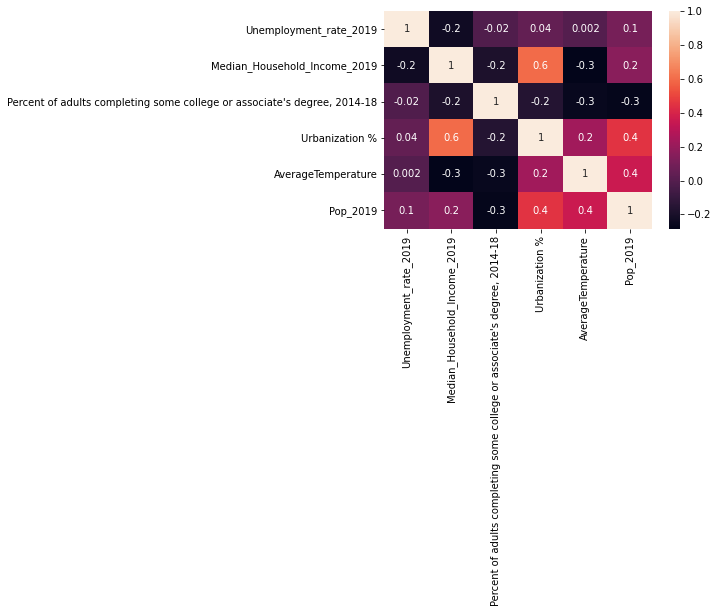

In [55]:
#Examine correlations
stateEducationDataset = pd.read_csv("data/cleaned/educationStateDataset.csv")

colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "Percent of adults completing some college or associate's degree, 2014-18",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019"]

predictorDataset = stateEducationDataset[colNames]
predictorDataset.set_index("FIPS Code", inplace=True)
ax = sns.heatmap(predictorDataset.corr(), annot = True, fmt = '.1g')
plt.show()

In [81]:
### Load in state abbreviations to create single output dataframe ###
stateAbbreviations = pd.read_csv("data/US_state_abb.csv")
statePopulations = pd.read_csv("data/us_pop.csv")
#print(statePopulations)

### Load in covid data ###
usDailyCleaned = pd.read_csv("data/cleaned/daily_df.csv")

cols = ["date","deathIncrease","state_abb"]
usDailyCleaned = usDailyCleaned[cols]
usDailyCleaned = usDailyCleaned.fillna(0)

states = usDailyCleaned.groupby("state_abb")

outputCount = pd.DataFrame()
outputCount["Total"] = states["deathIncrease"].agg(np.sum)
outputCount = outputCount.reset_index()
outputCount = outputCount.rename(columns={"state_abb":"ABBREVIATION","US State":"state"})
outputCount = outputCount.merge(stateAbbreviations, how="left", on="ABBREVIATION")
outputCount = outputCount.drop(columns=["ABBREVIATION"])
outputCount = outputCount.rename(columns={"US State":"state"})
outputCount = outputCount.merge(statePopulations,how='left',on="state").dropna()
outputCount["Output"] = (outputCount["Total"]/outputCount["Pop_2019"])*100
outputCount = outputCount.drop(columns=["Pop_2019","Total"])

#print(outputCount)

### Load in misinformation data ###
stateMisinformation = pd.read_csv("data/cleaned/trend_all_time_state.csv")

cols = ["state","covid_conspiracy","covid_hoax","plandemic"]
colsToAvg = ["covid_conspiracy","covid_hoax","plandemic"]
stateMisinformation = stateMisinformation[cols]

stateMisinformation["Misinformation Mean"] = round(stateMisinformation[cols].mean(axis=1),2)

#print(stateMisinformation)

### Load in mobility data ###
stateMobility = pd.read_csv("data/cleaned/US_mobility_state_cleaned.csv")

cols = ["state","non_residential_percent_change_from_baseline"]
stateMobility = stateMobility[cols]

statesMobilityGroups = stateMobility.groupby("state")

mobilityStateAvg = pd.DataFrame()
mobilityStateAvg["Mobility"] = round(statesMobilityGroups["non_residential_percent_change_from_baseline"].agg(np.mean),2)

#print(mobilityStateAvg)

#Define output array

dependentVarsDf = pd.DataFrame()
dependentVarsDf["state"] = stateMisinformation["state"]
dependentVarsDf["Misinformation Index"] = stateMisinformation["Misinformation Mean"]
dependentVarsDf = dependentVarsDf.merge(outputCount,how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(mobilityStateAvg,how='left',on='state')
dependentVarsDf = dependentVarsDf.rename(columns={"state":"State"})


print(dependentVarsDf)

                   state    Output
0                 Alaska  0.039369
1                Alabama  0.190611
2               Arkansas  0.176055
4                Arizona  0.206946
5             California  0.120234
6               Colorado  0.101376
7            Connecticut  0.209689
8   District of Columbia  0.139568
9               Delaware  0.135146
10               Florida  0.138860
11               Georgia  0.153267
13                Hawaii  0.030158
14                  Iowa  0.168174
15                 Idaho  0.101060
16              Illinois  0.175381
17               Indiana  0.181961
18                Kansas  0.155184
19              Kentucky  0.097053
20             Louisiana  0.202009
21         Massachusetts  0.226667
22              Maryland  0.126206
23                 Maine  0.048653
24              Michigan  0.161813
25             Minnesota  0.113305
26              Missouri  0.121712
28           Mississippi  0.219209
29               Montana  0.124815
30        North Caro

In [80]:
#Merge independent and dependent variables to create a single dataframe to run out regression
predictorDataset = predictorDataset.drop(columns=["State"])
predictorDataset = predictorDataset.rename(columns={"Area Name":"State"})
df = predictorDataset.merge(dependentVarsDf,on="State",how='left')
print(df)

KeyError: 'State'

In [69]:
xcols = ["Unemployment_rate_2019",
        "Median_Household_Income_2019",
        "Percent of adults completing some college or associate's degree, 2014-18",
        "Urbanization %",
        "AverageTemperature",
        "Pop_2019"]
X = df[xcols]

In [ ]:
#Regression for misinformation
ycols = ["Misinformation Index"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

In [70]:
#Regression for mobility
ycols = ["Mobility"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Mobility   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     14.24
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           7.38e-09
Time:                        15:26:38   Log-Likelihood:                -165.80
No. Observations:                  50   AIC:                             345.6
Df Residuals:                      43   BIC:                             359.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
const                                                                       58.7445     17.087      3.438      0.001      24.284      93.205
Unemployment_rate_2019                                                      -3.0591      1.442     -2.122      0.040      -5.967      -0.151
Median_Household_Income_2019                                                -0.0005      0.000     -2.881      0.006      -0.001      -0.000
Percent of adults completing some college or associate's degree, 2014-18     0.1638      0.322      0.508      0.614      -0.486       0.814
Urbanization %                                                              -0.1388      0.115     -1.205      0.235      -0.371       0.093
AverageTemperature                                                          -1.3914      0.292     -4.759      0.000      -1.981      -0.802
Pop_2019                                                                 -1.553e-07   1.66e-07     -0.936      0.354    -4.9e-07    1.79e-07
==============================================================================
Omnibus:                        4.818   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                3.679
Skew:                          -0.588   Prob(JB):                        0.159
Kurtosis:                       3.621   Cond. No.                     1.65e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
#Regression for covid
ycols = ["Output"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

KeyError: "None of [Index(['Output'], dtype='object')] are in the [columns]"